# Random Forest Classification

Este es un template de como manejariamos un modelo de propensión con Random Forest

Es importante setear antes de iniciar algunas variables de entorno

#### Linux / MAC

```{bash}
export BUCKET_MODEL=belc-bigdata-models-dlk-qas
export FOLDER_MODEL=template-model
export ENV_DEPLOY=QAS
export MLFLOW_HOST=internal-alb-datalake-casetwo-qas-45252694.us-east-1.elb.amazonaws.com
```


In [1]:
%env BUCKET_MODEL=belc-bigdata-models-dlk-qas
%env FOLDER_MODEL=template-model
%env ENV_DEPLOY=QAS
%env MLFLOW_HOST=internal-alb-datalake-casetwo-qas-45252694.us-east-1.elb.amazonaws.com

env: BUCKET_MODEL=belc-bigdata-models-dlk-qas
env: FOLDER_MODEL=template-model
env: ENV_DEPLOY=QAS
env: MLFLOW_HOST=internal-alb-datalake-casetwo-qas-45252694.us-east-1.elb.amazonaws.com


In [2]:
import os
import source.utils.mlflow as ml
from datetime import datetime
import source.utils.configvariables as uc

/Users/manuel/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# Configuracion MLFlow

Seteamos algunas variable principales para iniciar nuestro proyecto

In [4]:
ml_flow_host = uc.env_ml_flow_host
ml_flow_project = uc.env_ml_flow_project

In [5]:
Myflow = ml.MLFlowTracking(ml_flow_host)

In [6]:
run_name = 'Propensity_RanfomForest'
folder = 'propensity'
target = 'Loan_Status'
seed = 12345

## Iniciamos el experimento

Iniciamos el experimiento en la herramienta mlflow

In [7]:
active_run = Myflow.start_experiment(ml_flow_project, run_name=run_name)
active_run

<ActiveRun: >

In [8]:
dict_tags = {"Enviroment":uc.env_deploy,
             "Grupo":"Template",
             "Proyecto":"Propensity"}

Myflow.model_logging_tags(dict_tags)

In [9]:
dict_params = {"pipeline":"validation",
               "country":"CORP"}

Myflow.model_logging_params(dict_params)

## Preparación de Datos

In [10]:
file_name_data_train = "data_test/train_preprocessed.csv"
file_name_data_test = "data_test/test_preprocessed.csv"

In [11]:
train = pd.read_csv(file_name_data_train)
test = pd.read_csv(file_name_data_test)

In [12]:
train.head(1)

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,TotalIncome,TotalIncomeByPerson,Cuota,%Cuota,Loan_Status
0,0.0,0.066422,0.0,0.170767,0.72973,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.04797,0.064711,0.076574,0.078223,1


In [13]:
test.head(1)

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,TotalIncome,TotalIncomeByPerson,Cuota,%Cuota,Loan_Status
0,0.333333,0.024735,0.0,0.075253,0.72973,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.010633,0.005578,0.033744,0.067586,1


In [14]:
def plot_roc_curve(y, y_proba, label = '', path=None):
    '''
    plot roc curve for target and probabilities
    
    params:
    y: original target
    y_proba: model probabilities
    label: model label
    path: path to log on MLFlow
    '''
    
    auc_roc = roc_auc_score(y, y_proba)
    fpr, tpr, thresholds = roc_curve(y, y_proba)
    
    plt.figure(figsize=(8,6))
    plt.rcParams.update({'font.size': 12})
    plt.plot(fpr, fpr, c = 'red')
    plt.plot(fpr, tpr, label= (f"Curva ROC {label} (AUC = {auc_roc:.4f})"))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"Curva ROC {label}")
    plt.legend(loc=4, numpoints=1)
    
    plt.show()
    
    #save to MLFlow
    if path:
        plt.savefig(path)

In [15]:
def get_feature_importances(model, columns):
    '''
    get a dataframe with feature importances for the model
    
    params:
    model: trained model
    columns: column names used for the model
    '''
    
    importances = pd.DataFrame({'columna': columns, 'importance': model.feature_importances_})
    importances = importances.sort_values(by = 'importance', ascending = False)
    return importances

In [16]:
def get_best_params(model, param_grid, metric, X_train, y_train):
    '''
    train with cross validation 
    
    params:
    model, param_grid, metric: params for the grid search object
    X_train, y_train: dataset for model fitting
    '''
    
    gs = GridSearchCV(estimator = model, param_grid = param_grid, scoring = metric)
    gs.fit(X_train, y_train)
    
    gs_report = {}
    
    gs_report['results'] = pd.DataFrame(gs.cv_results_)
    gs_report['best_params'] = gs.best_params_
    gs_report['best_model'] = gs.best_estimator_
    
    return gs_report

### Trabajamos con el modelo

In [17]:
start_model = datetime.now()
current_time = start_model.strftime("%H:%M:%S")
print("Current Time is :", current_time)

# registramos el inicio del train
dict_params = {"train_time1_start":current_time}
Myflow.model_logging_params(dict_params)

Current Time is : 15:01:41


#### Training

In [18]:
X_train = train.drop(target, axis = 1)
y_train = train[target]

X_test = test.drop(target, axis = 1)
y_test = test[target]

In [19]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [5, 10],
          'min_samples_split': [25, 50],
          'n_estimators': [25, 50],
          'random_state': [seed]}

In [20]:
report = get_best_params(RandomForestClassifier(), params, 'roc_auc', X_train, y_train)
best_model = report['best_model']
best_params = report['best_params']
results = report['results']

In [21]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.033440,0.003651,0.004508,0.000482,gini,5,25,25,12345,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.724858,0.784304,0.784304,0.773712,0.705392,0.754514,0.032973,6
1,0.056978,0.001639,0.005798,0.000673,gini,5,25,50,12345,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.731025,0.776601,0.786230,0.771786,0.719608,0.757050,0.026571,5
2,0.029576,0.000492,0.003959,0.000079,gini,5,50,25,12345,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.715133,0.773712,0.789119,0.787193,0.682843,0.749600,0.042897,13
3,0.055812,0.002441,0.005400,0.000118,gini,5,50,50,12345,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.716082,0.749639,0.810785,0.789119,0.700000,0.753125,0.042016,7
4,0.029558,0.000140,0.003807,0.000031,gini,10,25,25,12345,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.728178,0.769860,0.809822,0.772268,0.723039,0.760634,0.031958,3
5,0.057935,0.000878,0.005399,0.000111,gini,10,25,50,12345,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.732922,0.764083,0.792971,0.772749,0.724510,0.757447,0.025403,4
6,0.028866,0.000362,0.003844,0.000086,gini,10,50,25,12345,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.722486,0.769860,0.799230,0.794896,0.735294,0.764353,0.030909,1
7,0.056706,0.001052,0.005637,0.000287,gini,10,50,50,12345,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.726755,0.757824,0.805489,0.788637,0.728922,0.761525,0.031475,2
8,0.029783,0.000530,0.003936,0.000212,entropy,5,25,25,12345,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.725095,0.741454,0.791045,0.778527,0.718627,0.750950,0.028884,10
9,0.059997,0.004048,0.005794,0.000473,entropy,5,25,50,12345,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.715370,0.765527,0.777564,0.777082,0.717157,0.750540,0.028322,11


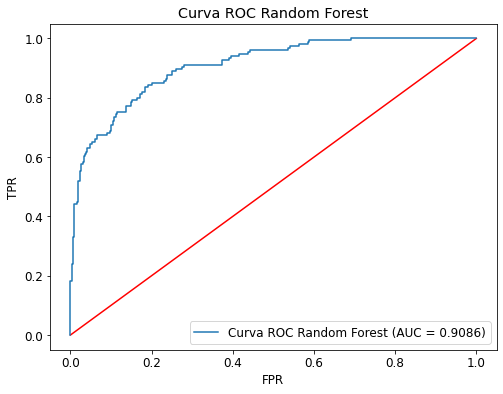

<Figure size 432x288 with 0 Axes>

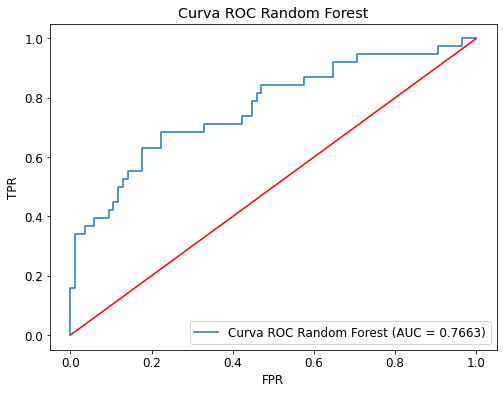

<Figure size 432x288 with 0 Axes>

In [22]:
y_train_pred = best_model.predict_proba(X_train)[:,1]
y_test_pred = best_model.predict_proba(X_test)[:,1]

auc_train = roc_auc_score(y_train, y_train_pred) 
auc_test = roc_auc_score(y_test, y_test_pred) 

plot_roc_curve(y_train, y_train_pred, 'Random Forest', "train.png")
plot_roc_curve(y_test, y_test_pred, 'Random Forest', "test.png")

In [23]:
end_model = datetime.now()
current_time = end_model.strftime("%H:%M:%S")

# registramos el fin del train
dict_params = {"train_time2_end":current_time}
Myflow.model_logging_params(dict_params)

dif_time = end_model-start_model
# registramos el diferencia del train
dict_params = {"train_time3_duration":dif_time}
Myflow.model_logging_params(dict_params)

In [24]:
dict_metrics = {"auc_train":auc_train, "auc_test":auc_test}
Myflow.model_logging_metrics(dict_metrics)

### Exportar data

In [ ]:
# Myflow.model_logging_artifact("train.png", "results")
# Myflow.model_logging_artifact("test.png", "results")

In [ ]:
# results.to_csv("resultado.csv")
# Myflow.model_logging_artifact("resultado.csv", "data")

# Para descargar información del experimiento hacia el local

In [27]:
# Myflow.download_artifacts("results","images")

## Terminando el experimento

In [28]:
Myflow.end_experiment()